In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)

In [2]:
import numpyro.distributions as dist
from hbmep.model import Baseline


class RectifiedLogistic(Baseline):
    LINK = "rectified_logistic"

    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, l, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -l + jnp.true_divide(
                    H + l,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + l, l),
                                v
                            ),
                            jnp.exp(-b * (x - a))
                        ),
                        1 / v
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_l = numpyro.sample("global_sigma_l", dist.HalfNormal(100))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=50))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=100))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, jnp.multiply(global_sigma_b, sigma_b_raw))

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, jnp.multiply(global_sigma_v, sigma_v_raw))

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, jnp.multiply(global_sigma_L, sigma_L_raw))

                sigma_l_raw = numpyro.sample("sigma_l_raw", dist.HalfNormal(scale=1))
                sigma_l = numpyro.deterministic("sigma_l", jnp.multiply(global_sigma_l, sigma_l_raw))

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, jnp.multiply(global_sigma_H, sigma_H_raw))

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", jnp.multiply(global_sigma_g_1, sigma_g_1_raw))

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", jnp.multiply(global_sigma_g_2, sigma_g_2_raw))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=sigma_a, rate=1))
                    a = numpyro.deterministic(site.a, jnp.true_divide(jnp.multiply(a_raw, mu_a), sigma_a))

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(sigma_b, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(sigma_v, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(sigma_L, L_raw))

                    l_raw = numpyro.sample("l_raw", dist.HalfNormal(scale=1))
                    l = numpyro.deterministic("l", jnp.multiply(sigma_l, l_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(sigma_H, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(sigma_g_1, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(sigma_g_2, g_2_raw))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        l=l[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta, jnp.true_divide(g_2[subject, feature0], g_1[subject, feature0] + mu)
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    obs=response_obs
                )


In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/link-comparison/proc-2023-10-27/uninjured-link-comparison/rectified_logistic.toml"
config = Config(toml_path=toml_path)
config.MCMC_PARAMS["num_warmup"] = 5000
config.MCMC_PARAMS["num_samples"] = 1000

model = RectifiedLogistic(config=config)


2023-11-08 12:42:17,511 - hbmep.config - INFO - Verifying configuration ...
2023-11-08 12:42:17,511 - hbmep.config - INFO - Success!
2023-11-08 12:42:17,525 - hbmep.model.baseline - INFO - Initialized model with rectified_logistic link


In [4]:
src = "/home/vishu/data/hbmep-processed/human/tms/data_pkpk_auc_proc-2023-10-27.csv"
df = pd.read_csv(src)

# ind = df[model.features[0]].isin(["Uninjured"])
# df = df[ind].reset_index(drop=True).copy()

# subset = ["SCA01"]
# subset = ["SCA01", "SCA02", "SCA03"]
# ind = df[model.subject].isin(subset)
# df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)


2023-11-08 12:42:17,565 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/uninjured-link-comparison/rectified_logistic
2023-11-08 12:42:17,565 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/uninjured-link-comparison/rectified_logistic
2023-11-08 12:42:17,566 - hbmep.dataset.core - INFO - Processing data ...
2023-11-08 12:42:17,567 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [6]:
c = (0, 0)
ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()



In [26]:
t = temp_df.groupby(by=[model.intensity], as_index=False).agg({response: ["mean", "std"] for response in model.response})
t


TMSInt  PKPK_ADM            PKPK_APB           PKPK_Biceps            \
              mean       std      mean       std        mean       std   
0    0.0  0.008274       NaN  0.005603       NaN    0.005789       NaN   
1   30.0  0.008210  0.000646  0.007418  0.001201    0.005694  0.000903   
2   33.0  0.007611  0.000740  0.006841  0.000592    0.006035  0.001180   
3   37.0  0.011218  0.005454  0.114452  0.133758    0.006014  0.000923   
4   41.0  0.059694  0.040054  0.483969  0.325365    0.005604  0.001156   
5   44.0  0.151620  0.110820  0.895464  0.341575    0.005965  0.000772   
6   48.0  0.579902  0.390962  1.022758  0.152519    0.006552  0.001318   
7   52.0  0.738826  0.334530  1.118798  0.368053    0.007479  0.002684   
8   59.0  1.011707  0.267798  1.137277  0.338960    0.008565  0.005497   
9   65.0  1.089767  0.191604  0.875641  0.229563    0.006862  0.001310   

   PKPK_ECR            PKPK_FCR           PKPK_Triceps            
       mean       std      mean       std         mean       std  
0  0.006660       NaN  0.008533       NaN     0.006569       NaN  
1  0.005878  0.000664  0.008294  0.000847     0.006733  0.001284  
2  0.005813  0.000775  0.007469  0.000819     0.006531  0.001158  
3  0.010213  0.007252  0.008105  0.001139     0.007677  0.001750  
4  0.020860  0.016514  0.019004  0.024771     0.007145  0.001103  
5  0.069626  0.029023  0.016048  0.008947     0.006935  0.001516  
6  0.100556  0.016375  0.029297  0.016195     0.006790  0.000870  
7  0.126074  0.026409  0.036319  0.013851     0.007029  0.001279  
8  0.123048  0.029157  0.060828  0.029228     0.007555  0.001264  
9  0.103605  0.013662  0.067261  0.045884     0.007499  0.001595

In [30]:
t[model.response[0]]["mean"]

0    0.008274
1    0.008210
2    0.007611
3    0.011218
4    0.059694
5    0.151620
6    0.579902
7    0.738826
8    1.011707
9    1.089767
Name: mean, dtype: float64

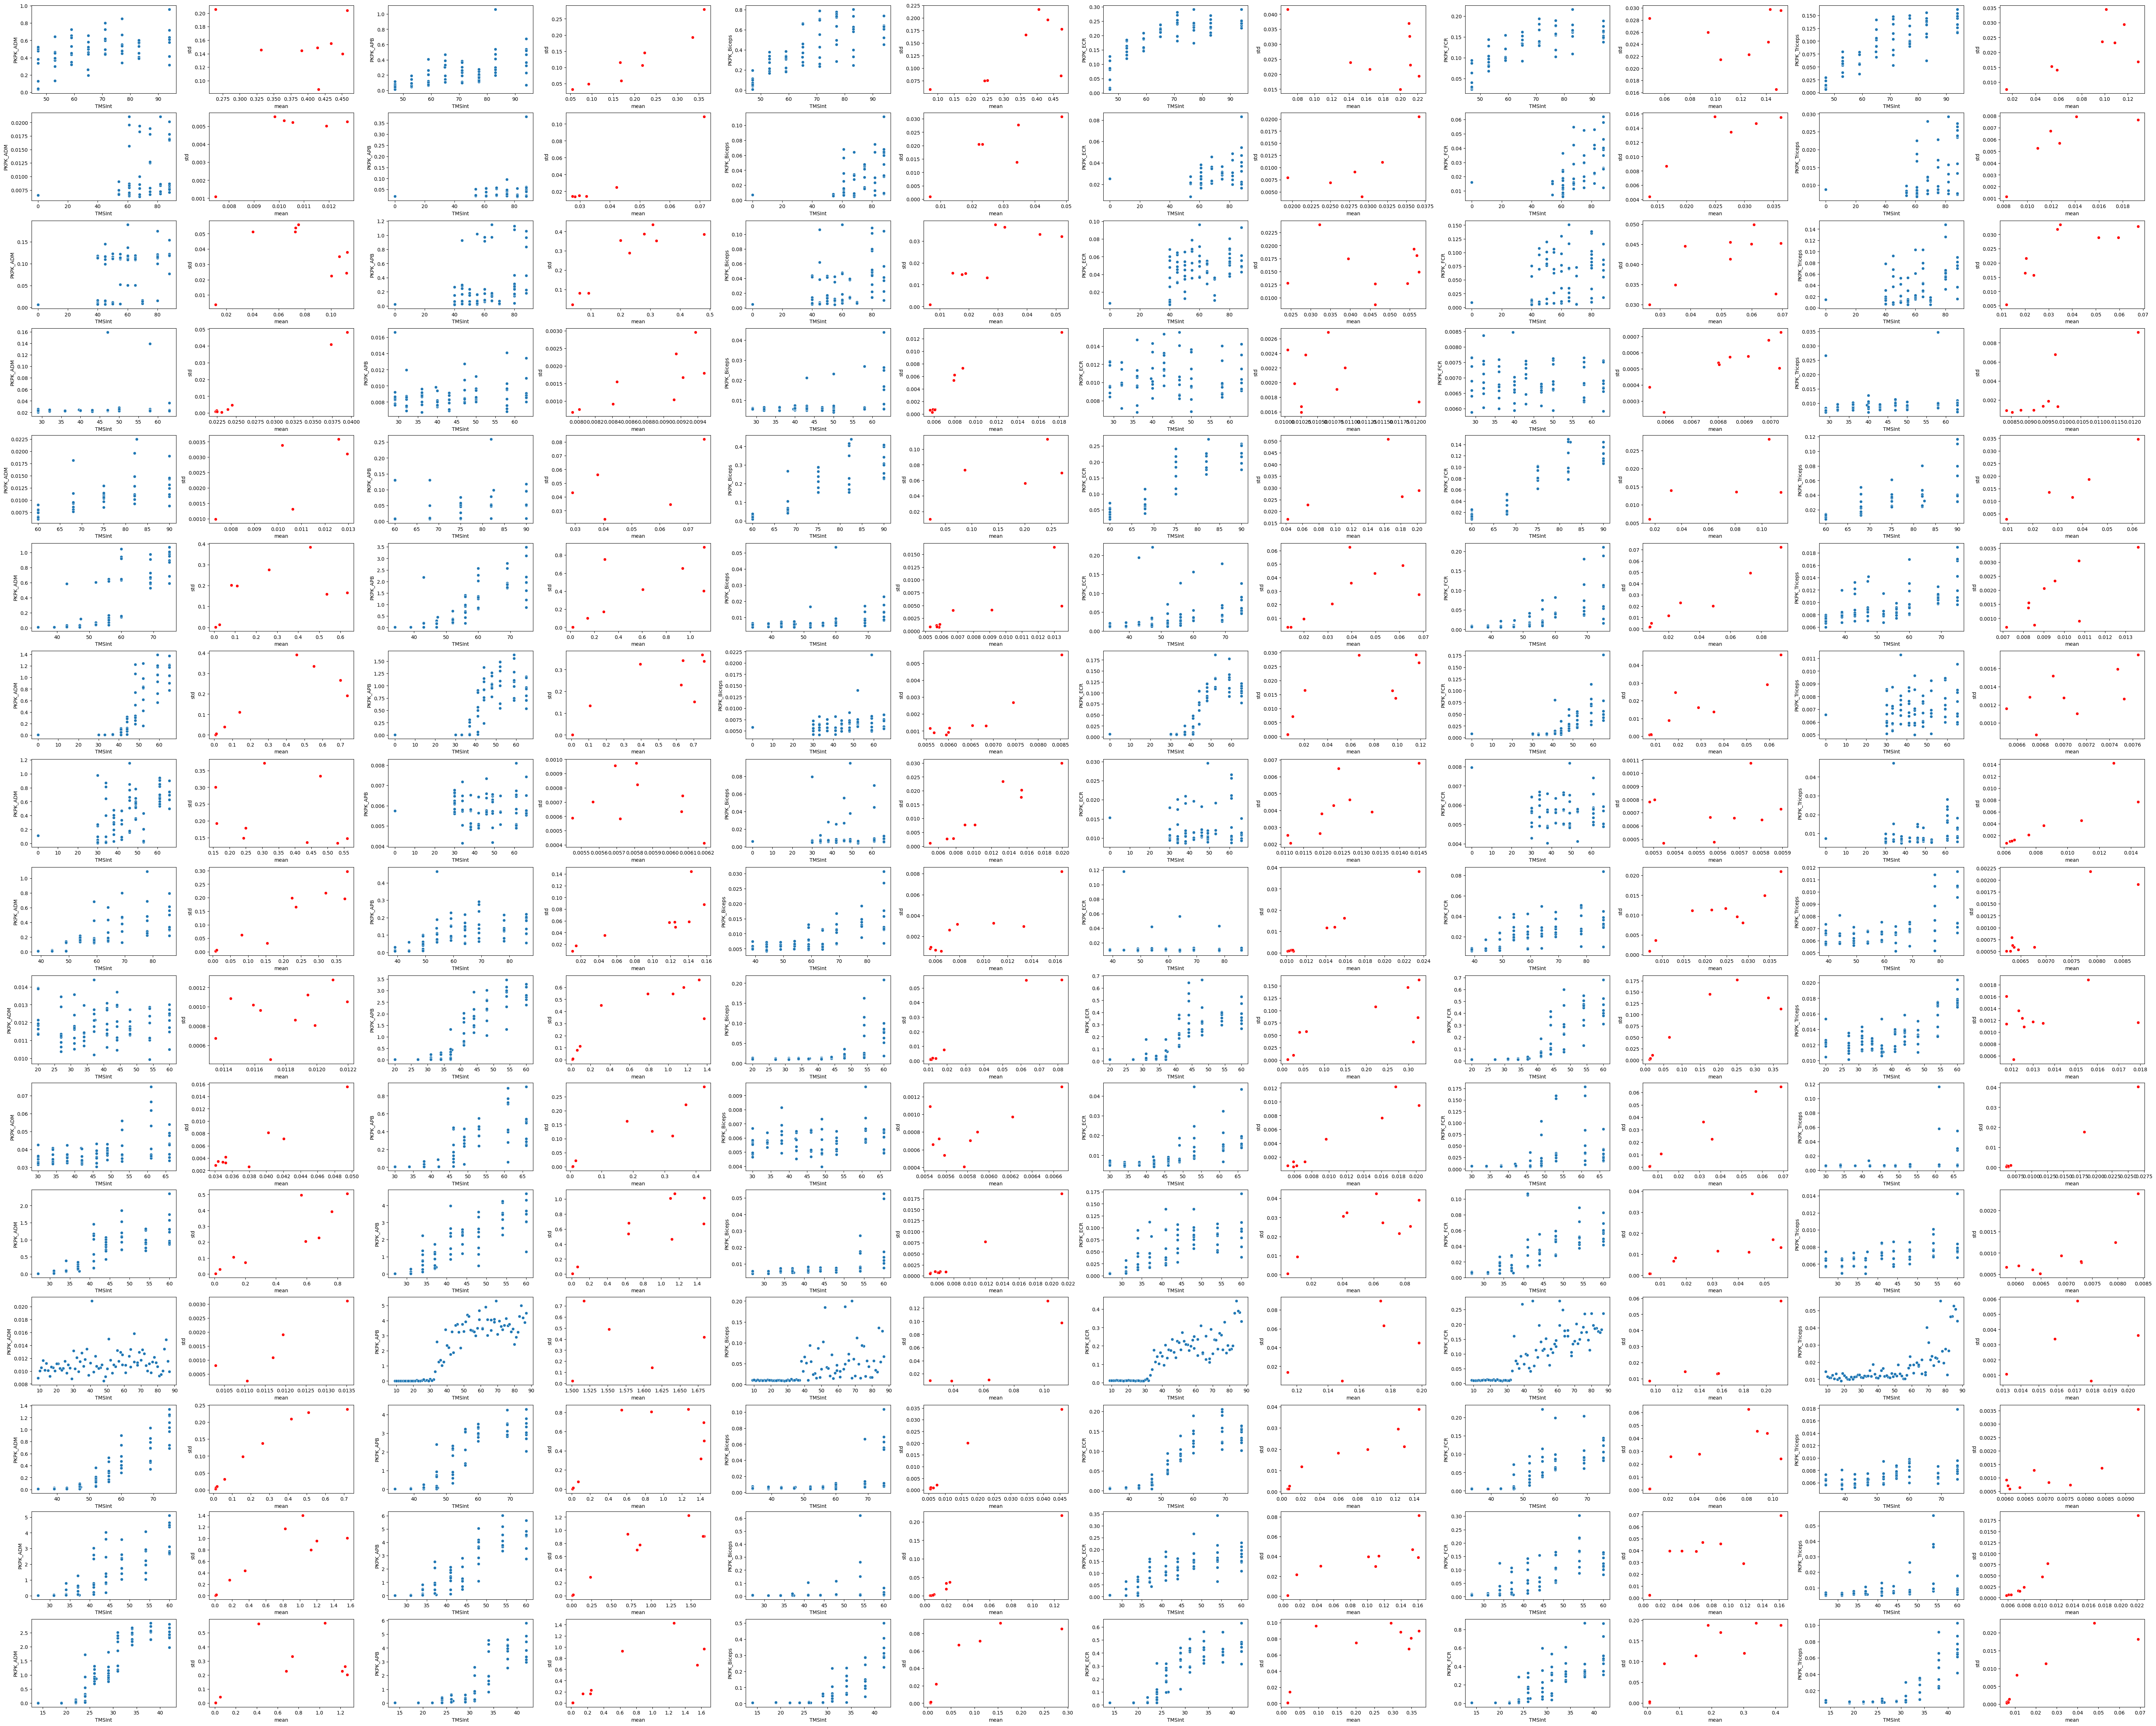

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

combinations = model._make_combinations(df=df, columns=model.combination_columns)
n_combinations = len(combinations)

nrows, ncols = n_combinations, 2 * model.n_response
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)

i = 0

for c in combinations:
    j = 0

    ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
    temp_df = df[ind].reset_index(drop=True).copy()
    t = temp_df.groupby(by=[model.intensity], as_index=False).agg({response: ["mean", "std"] for response in model.response})

    for response in model.response:
        ax = axes[i, j]
        sns.scatterplot(data=temp_df, x=model.intensity, y=response, ax=ax)
        j += 1

        ax = axes[i, j]
        sns.scatterplot(x=np.log(1 + t[response]["mean"]), y=t[response]["std"], ax=ax, color="red")
        j+= 1

    i += 1


In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-11-08 11:35:01,362 - hbmep.model.baseline - INFO - Running inference with rectified_logistic ...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

2023-11-08 11:46:58,933 - hbmep.utils.utils - INFO - func:run_inference took: 11 min and 57.57 sec


In [6]:
prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-08 11:46:59,072 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-11-08 11:47:02,403 - hbmep.utils.utils - INFO - func:predict took: 3.33 sec
2023-11-08 11:47:02,412 - hbmep.model.baseline - INFO - Rendering ...
2023-11-08 11:47:05,494 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/uninjured-link-comparison/rectified_logistic/recruitment_curves.pdf
2023-11-08 11:47:05,494 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 3.09 sec
2023-11-08 11:47:05,511 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-11-08 11:47:09,085 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/uninjured-link-comparison/rectified_logistic/posterior_predictive_check.pdf
2023-11-08 11:47:09,086 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 3.59 sec
2023-11-08 11:47:09,086 

In [7]:
mcmc.print_summary(prob=.95)



                         mean       std    median      2.5%     97.5%     n_eff     r_hat
       H_raw[0,0,0]      1.09      0.46      1.02      0.32      2.08     27.61      1.20
       H_raw[0,0,1]      1.35      0.65      1.19      0.36      2.39      4.13      1.81
       H_raw[0,0,2]      0.26      0.44      0.06      0.00      1.38      5.20      2.14
       H_raw[0,0,3]      0.90      0.54      0.85      0.07      1.89      5.68      1.46
       H_raw[0,0,4]      0.78      0.62      0.63      0.02      2.00     17.23      1.24
       H_raw[0,0,5]      0.73      0.53      0.61      0.00      1.67     13.25      1.32
       H_raw[1,0,0]      0.66      0.39      0.56      0.12      1.47     16.60      1.28
       H_raw[1,0,1]      0.55      0.55      0.47      0.00      1.58      7.08      1.29
       H_raw[1,0,2]      0.52      0.56      0.29      0.00      1.69      6.67      1.38
       H_raw[1,0,3]      0.54      0.60      0.32      0.00      1.88      7.50      1.36
       H_

In [10]:
numpyro_data = az.from_numpyro(mcmc)

""" Model evaluation """
logger.info("Evaluating model ...")

score = az.loo(numpyro_data)
logger.info(f"ELPD LOO (Log): {score.elpd_loo:.2f}")

score = az.waic(numpyro_data)
logger.info(f"ELPD WAIC (Log): {score.elpd_waic:.2f}")


2023-11-08 11:34:41,697 - __main__ - INFO - Evaluating model ...
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
2023-11-08 11:34:42,593 - __main__ - INFO - ELPD LOO (Log): 1286.53
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities

In [ ]:
import pickle

dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)


In [ ]:
dest = os.path.join(model.build_dir, "numpyro_data.nc")
az.to_netcdf(numpyro_data, dest)


'/home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/rectified_logistic/numpyro_data.nc'

In [18]:
posterior_samples["g_2"].mean(axis=0).max()

Array(3272.28571216, dtype=float64)